#   MEMORIAL UNIVERSITY
##  REINFORCEMENT LEARNING
### ASSIGNMENT PROJECT TWO

GROUP MEMBERS:
-   ADEJOKE ADEOYE
-   CEPHAS ACQUAH FORSON

##   INTRODUCTION
In this assignment, we experiment with learning policies for a simple reinforcement learning environment known as the 'gridworld'. We employ various methods to solve the gridworld problem and analyze the results.

#### Overview
In Part 1, we consider a 5x5 gridworld where each cell represents a possible state of the world with some special states. The agent can move up, down, left, or right, and the goal is to estimate the value function for each state and determine the optimal policy. This will be done using:
1. Solving the system of Bellman equations explicitly.
2. Iterative policy evaluation.
3. Value iteration.

In Part 2, the environment is modified by adding terminal states and changing the reward structure. The objectives are:
1. Use the Monte Carlo method with exploring starts and the ϵ-soft approach to learn an optimal policy.
2. Employ a behavior policy with equiprobable moves to learn an optimal policy using importance sampling.
3. Implement policy iteration to determine a suitable policy when the locations of certain special states permute with a given probability.


#   PART ONE
We start by setting up the environment.

In [194]:
#   ------Imports------
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import random

Plot the gridworld

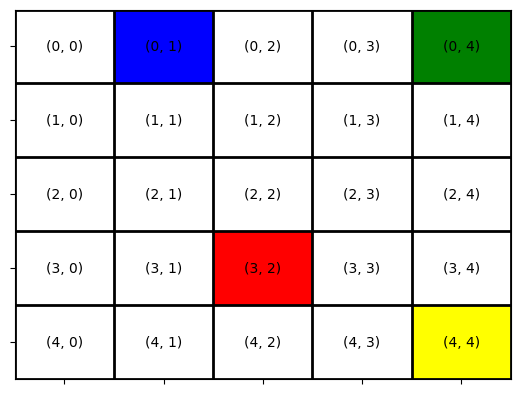

In [195]:
# Define the grid size
grid_size = 5

# Create a 5x5 grid
grid = np.zeros((grid_size, grid_size))

# Special states with their colors
special_states = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Plot the grid
fig, ax = plt.subplots()
ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
ax.tick_params(which='minor', size=0)

# Fill in the special states with colors
for (row, col), color in special_states.items():
    rect = plt.Rectangle((col - 0.5, row - 0.5), 1, 1, facecolor=color)
    ax.add_patch(rect)

# Label the cells with their row and column indices
for i in range(grid_size):
    for j in range(grid_size):
        ax.text(j, i, f'({i}, {j})', ha='center', va='center', color='black')

# Set limits and hide axes
ax.set_xlim(-0.5, grid_size - 0.5)
ax.set_ylim(grid_size - 0.5, -0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


Environment Set up.

In [196]:
#   the grid size and special state rewards
grid_size = 5
special_states = {
    1: {'reward': 5, 'next_state': 17},    # Blue state jumps to 17 (Red square)
    4: {'reward': 2.5, 'next_state': [24, 17]},  # Green state jumps to yellow or red
}

#   the action space (up, down, left, right)
actions = ['up', 'down', 'left', 'right']

#   function to get the next state and reward
def step(state, action):
    row, col = divmod(state, grid_size)
    if action == 'up':
        next_row, next_col = max(row - 1, 0), col
    elif action == 'down':
        next_row, next_col = min(row + 1, grid_size - 1), col
    elif action == 'left':
        next_row, next_col = row, max(col - 1, 0)
    elif action == 'right':
        next_row, next_col = row, min(col + 1, grid_size - 1)
    next_state = next_row * grid_size + next_col

    if state in special_states:
        reward = special_states[state]['reward']
        next_state = special_states[state]['next_state']
        if isinstance(next_state, list):
            next_state = np.random.choice(next_state)
    else:
        reward = -0.5 if next_state == state else 0

    return next_state, reward



#### Estimate the Value Function
#### Method 1: Solving the System of Bellman Equations Explicitly
For this method, we set up and solve the system of linear equations given by the Bellman equations.

In [197]:
#   discount factor
gamma = 0.95

# policy (equal probability for all actions)
policy = {s: {a: 0.25 for a in actions} for s in range(grid_size * grid_size)}

# Initialize  value function
V = np.ones(grid_size * grid_size)

# system of equations
A = np.eye(grid_size * grid_size)
b = np.zeros(grid_size * grid_size)

for state in range(grid_size * grid_size):
    if state in special_states:
        continue
    for action, prob in policy[state].items():
        next_state, reward = step(state, action)
        A[state, next_state] -= gamma * prob
        b[state] += prob * reward

# Solve the system of equations
V = solve(A, b)
V_explicit = V.reshape((grid_size, grid_size))
print("Value function (solving Bellman equations explicitly):")
print(V_explicit)


Value function (solving Bellman equations explicitly):
[[-0.95421     0.         -0.53544513 -0.54288433  0.        ]
 [-1.05667474 -0.63443929 -0.64986056 -0.68118352 -0.73491793]
 [-1.27751699 -0.96478801 -0.88518704 -0.94047832 -1.15197405]
 [-1.55372338 -1.26512197 -1.17197646 -1.24156411 -1.49673096]
 [-1.91931506 -1.63634149 -1.5427646  -1.6184526  -1.88544018]]


Plot in the gridworld

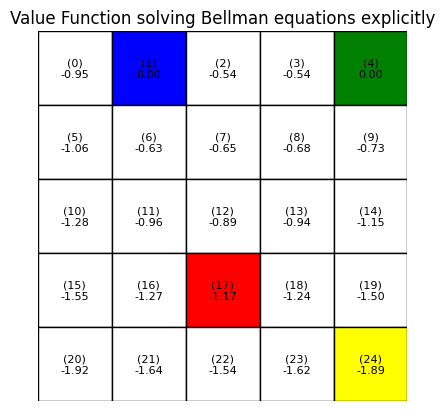

In [198]:
# Create the plot
fig, ax = plt.subplots()

# Define the colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(5):
    for j in range(5):
        state = i * 5 + j
        value = V_explicit[i, j]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{value:.2f}', ha='center', va='center', fontsize=8)

# Set the limits and aspect of the plot
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.axis('off')

# Show the plot
plt.title("Value Function solving Bellman equations explicitly")
plt.gca().invert_yaxis()
plt.show()


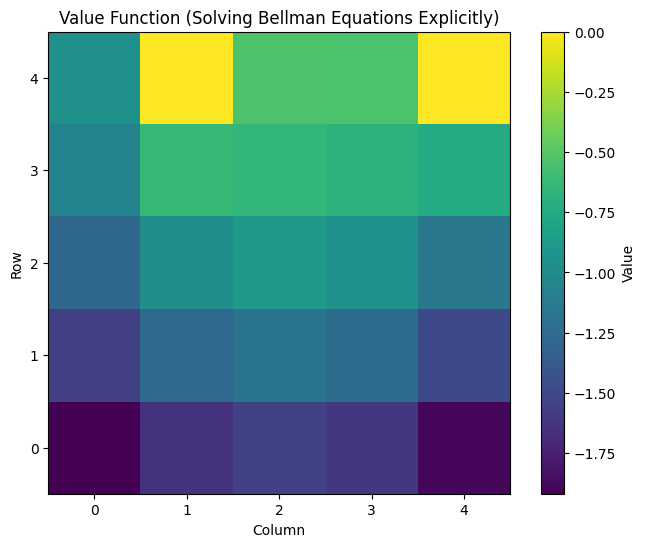

In [199]:
#   Function to plot heatmap
def plot_heatmap(V, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(np.flipud(V), cmap='viridis', interpolation='none')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.gca().invert_yaxis()
    plt.show()

# Plot the value functions
plot_heatmap(V_explicit, "Value Function (Solving Bellman Equations Explicitly)")


#### Method 2: Iterative Policy Evaluation

For this method, we iteratively update the policy function using the Bellman expectation equation until it converges.

In [200]:
# Initialize  value function
V = np.zeros(grid_size * grid_size)

# Define the threshold for convergence
theta = 1e-4
#   Iteration to update value function
while True:
    delta = 0
    for state in range(grid_size * grid_size):
        v = V[state]
        V[state] = sum(
            prob * (reward + gamma * V[next_state])
            for action, prob in policy[state].items()
            for next_state, reward in [step(state, action)]
        )
        delta = max(delta, abs(v - V[state]))
    if delta < theta:
        break
    
#   Print results
V_iterative = V.reshape((grid_size, grid_size))
print("Value function (iterative policy evaluation):")
print(V_iterative)


Value function (iterative policy evaluation):
[[ 2.17155941  4.73404193  2.0705914   1.26561096  1.77952418]
 [ 1.11859169  1.78253603  1.17442578  0.73947947  0.56278216]
 [ 0.16332994  0.47833429  0.35235202  0.11078276 -0.18585688]
 [-0.54641733 -0.284246   -0.27999307 -0.43954702 -0.74396943]
 [-1.10727602 -0.84885521 -0.80755538 -0.93760716 -1.23687123]]


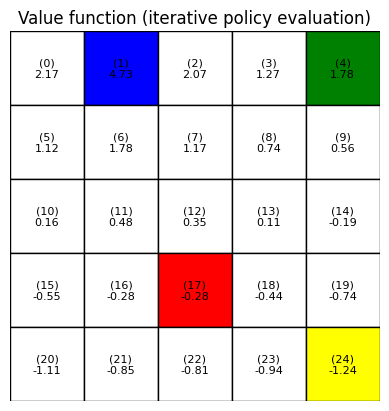

In [201]:
# Create the plot
fig, ax = plt.subplots()

# Define the colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(5):
    for j in range(5):
        state = i * 5 + j
        value = V_iterative[i, j]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{value:.2f}', ha='center', va='center', fontsize=8)

# Set the limits and aspect of the plot
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.axis('off')

# Show the plot
plt.title("Value function (iterative policy evaluation)")
plt.gca().invert_yaxis()
plt.show()


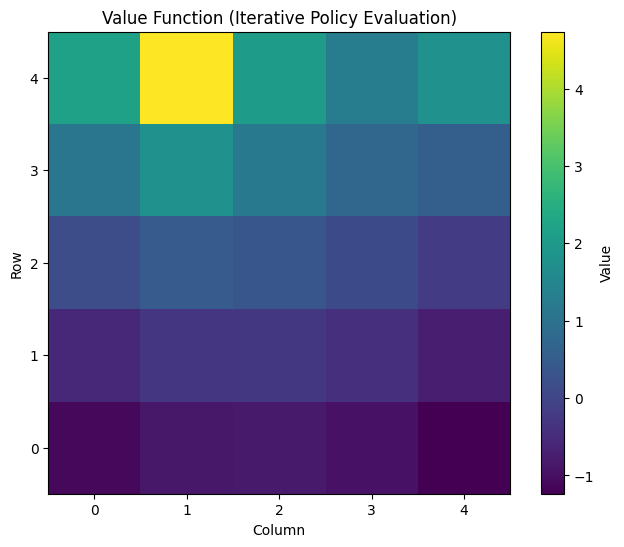

In [202]:
plot_heatmap(V_iterative, "Value Function (Iterative Policy Evaluation)")


#### Method 3: Value Iteration

For this method, we iteratively update the value function using the Bellman optimality equation until it converges.


In [203]:
# Initialize  value function
V = np.zeros(grid_size * grid_size)


while True:
    delta = 0
    for state in range(grid_size * grid_size):
        v = V[state]
        V[state] = max(
            sum(prob * (reward + gamma * V[next_state])
                for next_state, reward in [step(state, action)])
            for action, prob in policy[state].items()
        )
        delta = max(delta, abs(v - V[state]))
    if delta < theta:
        break

V_value_iteration = V.reshape((grid_size, grid_size))
print("Value function (value iteration):")
print(V_value_iteration)


Value function (value iteration):
[[2.97099502e-01 1.25094527e+00 2.97099502e-01 1.48662002e-01
  6.25945271e-01]
 [7.05611317e-02 2.97099502e-01 7.05611317e-02 3.53072254e-02
  1.48662002e-01]
 [1.67582688e-02 7.05611317e-02 1.67582688e-02 8.38546604e-03
  3.53072254e-02]
 [3.98008883e-03 1.67582688e-02 3.98008883e-03 1.99154819e-03
  8.38546604e-03]
 [9.45271098e-04 3.98008883e-03 9.45271098e-04 4.72992694e-04
  1.99154819e-03]]


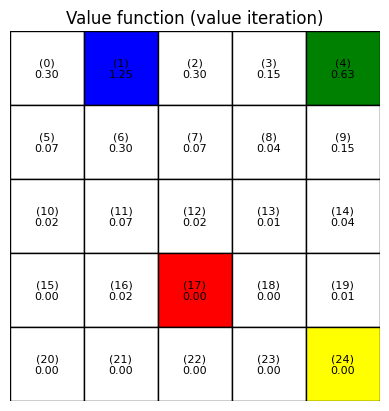

In [204]:
# Create  plot
fig, ax = plt.subplots()

# colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw  grid
for i in range(5):
    for j in range(5):
        state = i * 5 + j
        value = V_value_iteration[i, j]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{value:.2f}', ha='center', va='center', fontsize=8)

# limits and aspect of the plot
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.axis('off')

# Show the plot
plt.title("Value function (value iteration)")
plt.gca().invert_yaxis()
plt.show()


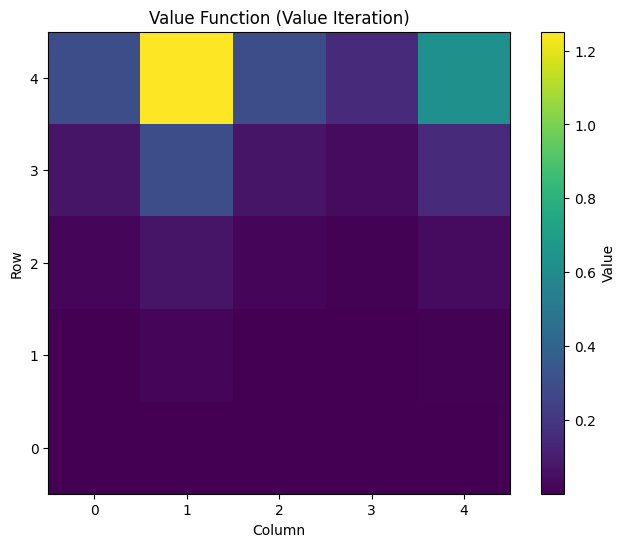

In [205]:
plot_heatmap(V_value_iteration, "Value Function (Value Iteration)")

In [206]:
# states with the highest value
highest_value_states_explicit = np.unravel_index(np.argmax(V_explicit), (grid_size, grid_size))
highest_value_states_iterative = np.unravel_index(np.argmax(V_iterative), (grid_size, grid_size))
highest_value_states_value_iteration = np.unravel_index(np.argmax(V_value_iteration), (grid_size, grid_size))

print(f"States with the highest value (solving Bellman equations explicitly): {highest_value_states_explicit}")
print(f"States with the highest value (iterative policy evaluation): {highest_value_states_iterative}")
print(f"States with the highest value (value iteration): {highest_value_states_value_iteration}")


States with the highest value (solving Bellman equations explicitly): (0, 1)
States with the highest value (iterative policy evaluation): (0, 1)
States with the highest value (value iteration): (0, 1)


##  PART 1.2

To determine the optimal policy for the gridworld problem, we will use three methods:

### 1. Explicitly Solving the Bellman Optimality Equation
We set up and solve a system of equations derived from the Bellman optimality equation to find the optimal policy.

Optimal policy (solving Bellman optimality equation):
[[1 0 3 1 0]
 [0 2 3 0 2]
 [1 1 2 0 0]
 [3 1 2 3 1]
 [3 0 2 3 0]]


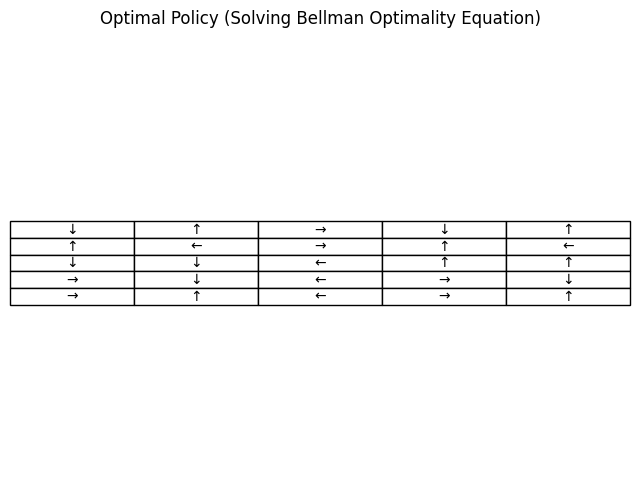

In [207]:
# grid size and special state rewards
grid_size = 5
special_states = {
    1: {'reward': 5, 'next_state': 17},    # Blue state
    4: {'reward': 2.5, 'next_state': [24, 17]},  # Green state
}

#   action space (up, down, left, right)
actions = ['up', 'down', 'left', 'right']

#  function to get the next state and reward
def step(state, action):
    row, col = divmod(state, grid_size)
    if action == 'up':
        next_row, next_col = max(row - 1, 0), col
    elif action == 'down':
        next_row, next_col = min(row + 1, grid_size - 1), col
    elif action == 'left':
        next_row, next_col = row, max(col - 1, 0)
    elif action == 'right':
        next_row, next_col = row, min(col + 1, grid_size - 1)
    next_state = next_row * grid_size + next_col

    if state in special_states:
        reward = special_states[state]['reward']
        next_state = special_states[state]['next_state']
        if isinstance(next_state, list):
            next_state = np.random.choice(next_state)
    else:
        reward = -0.5 if next_state == state else 0

    return next_state, reward

# Define the discount factor
gamma = 0.95

# Method 1: Solving the Bellman Optimality Equation Explicitly
V = np.zeros(grid_size * grid_size)
policy = np.zeros(grid_size * grid_size, dtype=int)
A = np.eye(grid_size * grid_size)
b = np.zeros(grid_size * grid_size)

for state in range(grid_size * grid_size):
    if state in special_states:
        continue
    for action in actions:
        next_state, reward = step(state, action)
        A[state, next_state] -= gamma
        b[state] += reward / 4  # Equal probability for each action

V = solve(A, b)
V_optimal = V.reshape((grid_size, grid_size))

# Derive the policy from the optimal value function
for state in range(grid_size * grid_size):
    if state in special_states:
        continue
    best_action_value = float('-inf')
    for action in actions:
        next_state, reward = step(state, action)
        action_value = reward + gamma * V[next_state]
        if action_value > best_action_value:
            best_action_value = action_value
            policy[state] = actions.index(action)

policy_optimal = policy.reshape((grid_size, grid_size))

print("Optimal policy (solving Bellman optimality equation):")
print(policy_optimal)

def plot_policy(policy, title):
    directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    policy_arrows = np.vectorize(directions.get)(policy)
    plt.figure(figsize=(8, 6))
    plt.table(cellText=policy_arrows, loc='center', cellLoc='center', cellColours=[['w']*grid_size]*grid_size)
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_policy(policy_optimal, "Optimal Policy (Solving Bellman Optimality Equation)")

Visualize

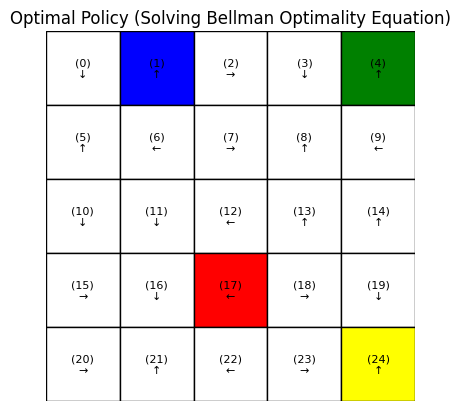

In [208]:
# Actions 
action_mapping = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Create the plot
fig, ax = plt.subplots()

# colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(5):
    for j in range(5):
        state = i * 5 + j
        action = policy_optimal[i, j]
        action_text = action_mapping[action]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{action_text}', ha='center', va='center', fontsize=8)

# limits and aspect of the plot
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Optimal Policy (Solving Bellman Optimality Equation)")

# Show the plot
plt.gca().invert_yaxis()
plt.show()


### 2. Policy Iteration with Iterative Policy Evaluation

We  use the policy iteration algorithm to find the optimal policy. This involves iterative policy evaluation and policy improvement.

Optimal policy (policy iteration):
[[3 0 2 2 1]
 [3 0 0 0 0]
 [3 0 0 0 0]
 [3 0 0 0 0]
 [3 0 0 0 0]]


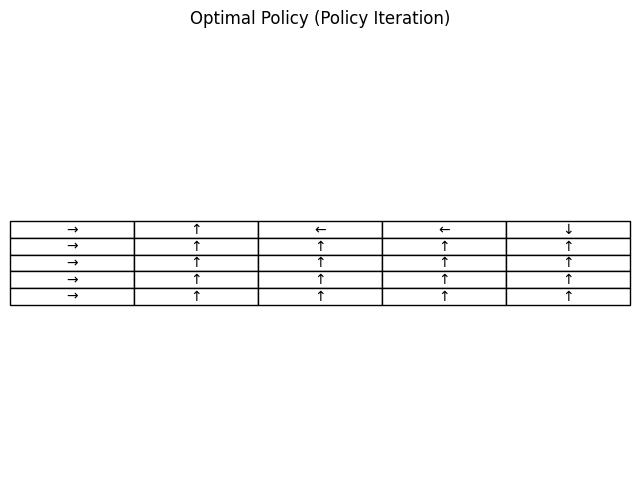

In [209]:
# Initialize the value function and policy
V = np.zeros(grid_size * grid_size)
policy = np.zeros((grid_size * grid_size, len(actions))) + 0.25

# Policy evaluation function
def policy_evaluation(policy, theta=1e-4, gamma=0.95):
    V = np.zeros(grid_size * grid_size)
    while True:
        delta = 0
        for state in range(grid_size * grid_size):
            v = V[state]
            V[state] = sum(
                prob * (reward + gamma * V[next_state])
                for action, prob in enumerate(policy[state])
                for next_state, reward in [step(state, actions[action])]
            )
            delta = max(delta, abs(v - V[state]))
        if delta < theta:
            break
    return V
    
# Policy improvement function
def policy_improvement(V, gamma=0.95):
    policy_stable = True
    new_policy = np.zeros((grid_size * grid_size, len(actions)))
    for state in range(grid_size * grid_size):
        action_values = np.zeros(len(actions))
        for action, action_prob in enumerate(actions):
            next_state, reward = step(state, actions[action])
            action_values[action] = reward + gamma * V[next_state]
        best_action = np.argmax(action_values)
        best_action_prob = np.zeros(len(actions))
        best_action_prob[best_action] = 1.0
        new_policy[state] = best_action_prob
        if not np.array_equal(new_policy[state], policy[state]):
            policy_stable = False
    return new_policy, policy_stable

policy_stable = False
while not policy_stable:
    V = policy_evaluation(policy)
    policy, policy_stable = policy_improvement(V)

policy_iteration = np.argmax(policy, axis=1).reshape((grid_size, grid_size))

print("Optimal policy (policy iteration):")
print(policy_iteration)

plot_policy(policy_iteration, "Optimal Policy (Policy Iteration)")

Visualize

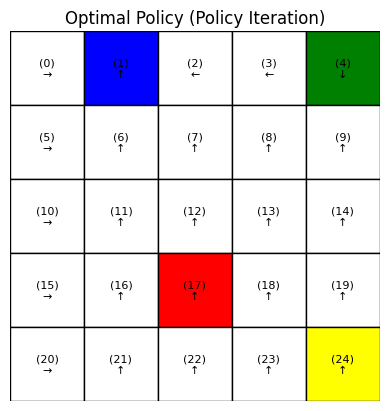

In [210]:
# Actions 
action_mapping = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Create the plot
fig, ax = plt.subplots()

# colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(5):
    for j in range(5):
        state = i * 5 + j
        action = policy_iteration[i, j]
        action_text = action_mapping[action]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{action_text}', ha='center', va='center', fontsize=8)

# limits and aspect of the plot
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Optimal Policy (Policy Iteration)")

# Show the plot
plt.gca().invert_yaxis()
plt.show()

### 3. Policy Improvement with Value Iteration

We  use the value iteration algorithm to find the optimal value function and derive the optimal policy.

Optimal policy (value iteration):
[[3 0 2 2 0]
 [3 0 0 0 0]
 [3 0 0 0 0]
 [3 0 0 0 0]
 [3 0 0 0 0]]


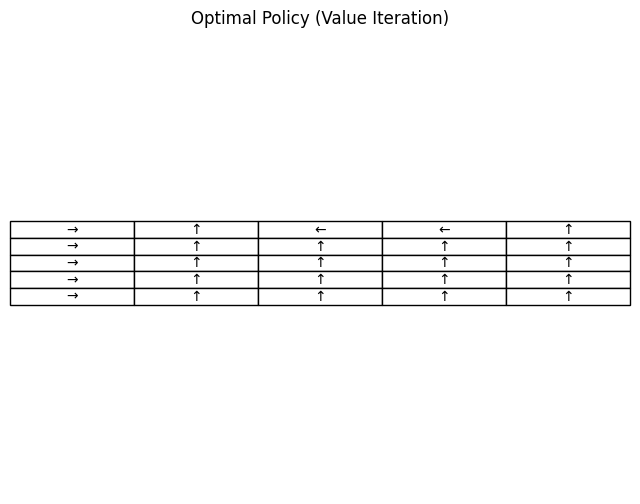

In [211]:
# Initialize the value function
V = np.zeros(grid_size * grid_size)

while True:
    delta = 0
    for state in range(grid_size * grid_size):
        v = V[state]
        V[state] = max(
            reward + gamma * V[next_state]
            for action in actions
            for next_state, reward in [step(state, action)]
        )
        delta = max(delta, abs(v - V[state]))
    if delta < theta:
        break

# Derive the policy from the optimal value function
policy_value_iteration = np.zeros(grid_size * grid_size, dtype=int)
for state in range(grid_size * grid_size):
    action_values = np.zeros(len(actions))
    for action, action_prob in enumerate(actions):
        next_state, reward = step(state, actions[action])
        action_values[action] = reward + gamma * V[next_state]
    best_action = np.argmax(action_values)
    policy_value_iteration[state] = best_action

policy_value_iteration = policy_value_iteration.reshape((grid_size, grid_size))

print("Optimal policy (value iteration):")
print(policy_value_iteration)

plot_policy(policy_value_iteration, "Optimal Policy (Value Iteration)")

Visualize

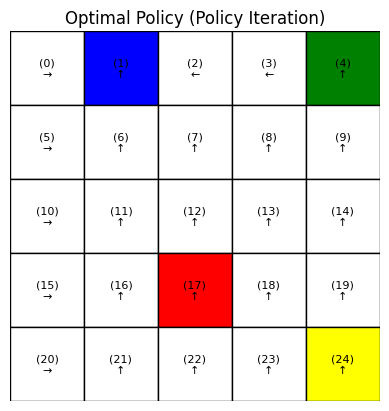

In [212]:
# Actions 
action_mapping = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Create the plot
fig, ax = plt.subplots()

# colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(5):
    for j in range(5):
        state = i * 5 + j
        action = policy_value_iteration[i, j]
        action_text = action_mapping[action]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{action_text}', ha='center', va='center', fontsize=8)

# limits and aspect of the plot
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Optimal Policy (Policy Iteration)")

# Show the plot
plt.gca().invert_yaxis()
plt.show()

## Part 2

#### Environment Setup
First, let's define the environment for the modified gridworld, including the transitions and rewards.

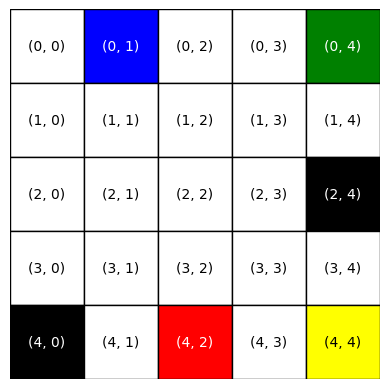

In [213]:
def plot_modified_gridworld():
    grid_size = 5
    colors = {
        (0, 1): 'blue',
        (0, 4): 'green',
        (4, 2): 'red',
        (4, 4): 'yellow',
        (4, 0): 'black',
        (2, 4): 'black'
    }
    
    fig, ax = plt.subplots()
    
    # Draw the grid
    for row in range(grid_size):
        for col in range(grid_size):
            
            color = colors.get((row, col), 'white')
            rect = plt.Rectangle((col, row), 1, 1, facecolor=color, edgecolor='black')
            ax.add_patch(rect)
            # Add cell location label
            font_color = 'black' if color == 'white' or color == 'yellow' else 'white'
            ax.text(col + 0.5, row + 0.5, f'({row}, {col})', ha='center', va='center', color=font_color)
    
    # Set the limits and aspect of the plot
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.gca().invert_yaxis()
    plt.show()

plot_modified_gridworld()



### 2.1: Monte Carlo Method with Exploring Starts and ϵ-Soft Approach

We  use the Monte Carlo method with exploring starts to estimate the value function and derive the optimal policy.


In [214]:
# Define the grid size and special state rewards
grid_size = 5
special_states = {
    (0, 1): {'reward': 5, 'next_state': (3, 2)},  # Blue state jumps to red state
    (0, 4): {'reward': 2.5, 'next_state': (4, 2)}, # Green state jumps to red
    (0, 4): {'reward': 2.5, 'next_state': (4, 4)},   # Green state jumps to yellow
    # (1, 4): {'reward': 2.5, 'next_state': (4, 4)} 
}

# Define terminal states
# terminal_states = [(4, 0), (3, 4)]
terminal_states = {
    (4, 0): {'reward': 0, 'next_state': state},  
    (3, 4): {'reward': 0, 'next_state': state}

}
# Define the action space (up, down, left, right)
actions = ['up', 'down', 'left', 'right']

# Define a function to get the next state and reward
def step(state, action):
    if state in terminal_states:
        return state, 0  # No movement from terminal states

    row, col = state
    if action == 'up':
        next_row, next_col = max(row - 1, 0), col
    elif action == 'down':
        next_row, next_col = min(row + 1, grid_size - 1), col
    elif action == 'left':
        next_row, next_col = row, max(col - 1, 0)
    elif action == 'right':
        next_row, next_col = row, min(col + 1, grid_size - 1)
    next_state = (next_row, next_col)

    if state in special_states:
        reward = special_states[state]['reward']
        next_state = special_states[state]['next_state']
        if isinstance(next_state, list):
            next_state = tuple(np.random.choice(next_state))
    else:
        reward = -0.2 if next_state != state else -0.5

    return next_state, reward

# Define the discount factor
gamma = 0.95

# Define the policy (equal probability for all actions)
policy = {s: {a: 0.25 for a in actions} for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}

# Monte Carlo method with exploring starts
def monte_carlo_es(episodes, gamma=0.95):
    Q = {s: {a: 0 for a in actions} for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}
    returns = {s: {a: [] for a in actions} for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}
    
    for episode in range(episodes):
        state = (np.random.choice(range(grid_size)), np.random.choice(range(grid_size)))
        action = np.random.choice(actions)
        episode_data = []
        
        while state not in terminal_states:
            next_state, reward = step(state, action)
            episode_data.append((state, action, reward))
            if next_state in terminal_states:
                break
            state = next_state
            action = np.random.choice(actions)
        
        G = 0
        for state, action, reward in reversed(episode_data):
            G = gamma * G + reward
            if (state, action) not in [(x[0], x[1]) for x in episode_data[:-1]]:
                returns[state][action].append(G)
                Q[state][action] = np.mean(returns[state][action])
    
    policy = {s: max(Q[s], key=Q[s].get) for s in Q}
    return policy, Q

# Monte Carlo method with epsilon-soft approach
def monte_carlo_epsilon_soft(episodes, epsilon=0.05, gamma=0.95):
    Q = {s: {a: 0 for a in actions} for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}
    returns = {s: {a: [] for a in actions} for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}
    
    for episode in range(episodes):
        state = (np.random.choice(range(grid_size)), np.random.choice(range(grid_size)))
        action = np.random.choice(actions)
        episode_data = []
        
        while state not in terminal_states:
            next_state, reward = step(state, action)
            episode_data.append((state, action, reward))
            if next_state in terminal_states:
                break
            state = next_state
            action = np.random.choice(actions, p=[epsilon / len(actions) + (1 - epsilon) if a == action else epsilon / len(actions) for a in actions])
        
        G = 0
        for state, action, reward in reversed(episode_data):
            G = gamma * G + reward
            if (state, action) not in [(x[0], x[1]) for x in episode_data[:-1]]:
                returns[state][action].append(G)
                Q[state][action] = np.mean(returns[state][action])
    
    policy = {s: max(Q[s], key=Q[s].get) for s in Q}
    return policy, Q


Optimal Policy (Monte Carlo Exploring Starts):
{(0, 0): 'up', (0, 1): 'up', (0, 2): 'up', (0, 3): 'up', (0, 4): 'up', (1, 0): 'up', (1, 1): 'up', (1, 2): 'up', (1, 3): 'up', (1, 4): 'up', (2, 0): 'up', (2, 1): 'up', (2, 2): 'up', (2, 3): 'up', (2, 4): 'up', (3, 0): 'up', (3, 1): 'up', (3, 2): 'up', (3, 3): 'up', (3, 4): 'up', (4, 0): 'up', (4, 1): 'up', (4, 2): 'up', (4, 3): 'up', (4, 4): 'down'}
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 1]


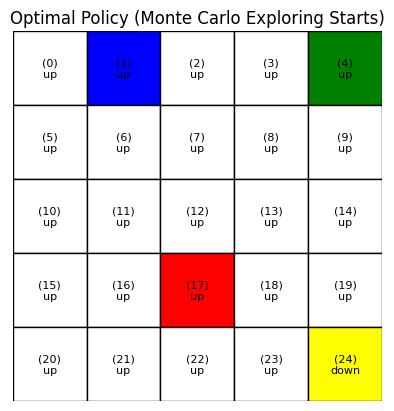

In [215]:
# Monte Carlo with exploring starts
policy_es, Q_es = monte_carlo_es(1000)
print("Optimal Policy (Monte Carlo Exploring Starts):")
print(policy_es)

# Initialize a 5x5 grid with zeros
grid_size = 5
policy_grid = np.zeros((grid_size, grid_size), dtype=int)

# Action to textual value mapping
action_mapping = {"up": 0, "down" : 1, "left ": 2, "right": 3}

# Populate the grid with numerical values based on the policy
for (row, col), action in policy_es.items():
    policy_grid[row, col] = action_mapping[action]

# Print the policy grid
for row in policy_grid:
    print(row)
    
# Action to textual value mapping
action_text_mapping = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}

# Create the plot
fig, ax = plt.subplots()

# Define the colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(grid_size):
    for j in range(grid_size):
        state = i * grid_size + j
        action = policy_grid[i, j]
        action_text = action_text_mapping[action]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{action_text}', ha='center', va='center', fontsize=8)

# Set the limits and aspect of the plot
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_aspect('equal')
ax.axis('off')

# Add a title to the plot
plt.title("Optimal Policy (Monte Carlo Exploring Starts)")

# Show the plot
plt.gca().invert_yaxis()
plt.show()


Optimal Policy (Monte Carlo Epsilon-Soft):
{(0, 0): 'up', (0, 1): 'up', (0, 2): 'up', (0, 3): 'up', (0, 4): 'up', (1, 0): 'up', (1, 1): 'up', (1, 2): 'up', (1, 3): 'up', (1, 4): 'up', (2, 0): 'up', (2, 1): 'up', (2, 2): 'up', (2, 3): 'up', (2, 4): 'up', (3, 0): 'up', (3, 1): 'up', (3, 2): 'up', (3, 3): 'up', (3, 4): 'up', (4, 0): 'up', (4, 1): 'up', (4, 2): 'up', (4, 3): 'up', (4, 4): 'down'}
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 1]


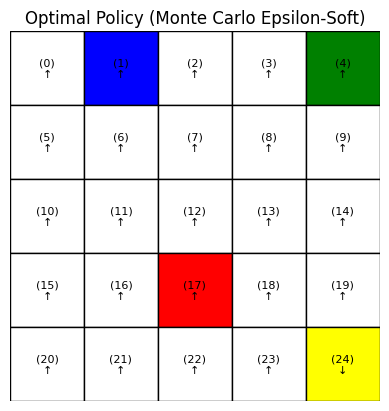

In [216]:
# Monte Carlo with epsilon-soft
policy_epsilon, Q_epsilon = monte_carlo_epsilon_soft(1000)
print("Optimal Policy (Monte Carlo Epsilon-Soft):")
print(policy_epsilon)

# Initialize a 5x5 grid with zeros
grid_size = 5
policy_grid = np.zeros((grid_size, grid_size), dtype=int)

# Populate the grid with numerical values based on the policy
for (row, col), action in policy_epsilon.items():
    policy_grid[row, col] = action_mapping[action]

# Print the policy grid
for row in policy_grid:
    print(row)
    
# Action to textual value mapping
action_text_mapping = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Create the plot
fig, ax = plt.subplots()

# Define the colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(grid_size):
    for j in range(grid_size):
        state = i * grid_size + j
        action = policy_grid[i, j]
        action_text = action_text_mapping[action]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{action_text}', ha='center', va='center', fontsize=8)

# Set the limits and aspect of the plot
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_aspect('equal')
ax.axis('off')

# Add a title to the plot
plt.title("Optimal Policy (Monte Carlo Epsilon-Soft)")

# Show the plot
plt.gca().invert_yaxis()
plt.show()


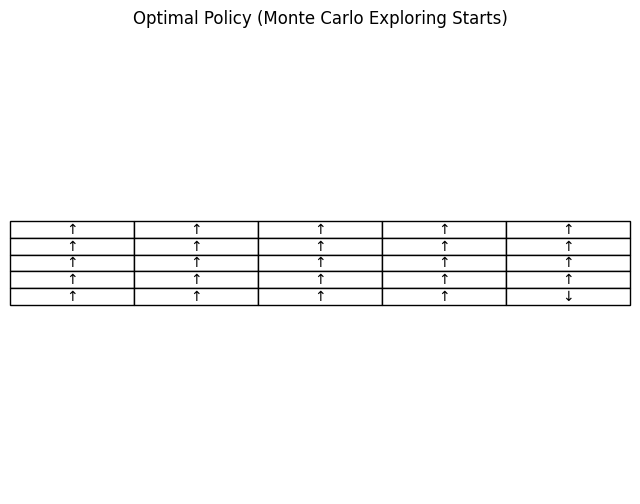

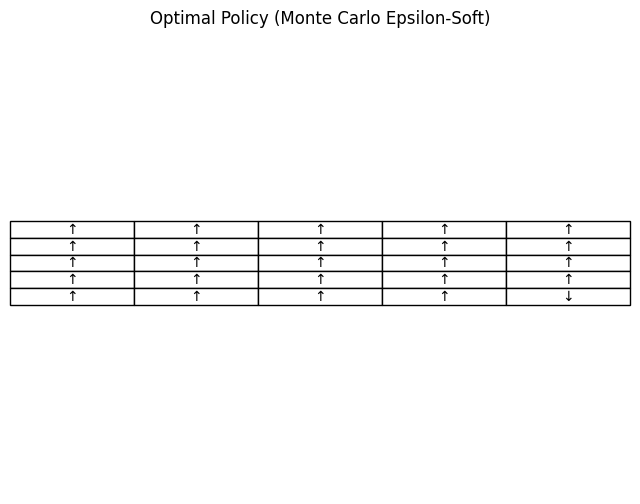

In [217]:
def plot_policy(policy, title):
    policy_grid = np.zeros((grid_size, grid_size), dtype=str)
    action_map = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
    
    for state, action in policy.items():
        row, col = state
        policy_grid[row, col] = action_map[action]
    
    plt.figure(figsize=(8, 6))
    plt.table(cellText=policy_grid, loc='center', cellLoc='center')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot the policies
plot_policy(policy_es, "Optimal Policy (Monte Carlo Exploring Starts)")
plot_policy(policy_epsilon, "Optimal Policy (Monte Carlo Epsilon-Soft)")

##  2.2 Monte Carlo control using weighted importance sampling

Optimal Policy (weighted importance sampling):
{(0, 0): 'right', (0, 1): 'left', (0, 2): 'down', (0, 3): 'right', (0, 4): 'down', (1, 0): 'up', (1, 1): 'up', (1, 2): 'left', (1, 3): 'down', (1, 4): 'right', (2, 0): 'up', (2, 1): 'right', (2, 2): 'up', (2, 3): 'up', (2, 4): 'up', (3, 0): 'up', (3, 1): 'left', (3, 2): 'left', (3, 3): 'up', (3, 4): 'right', (4, 0): 'down', (4, 1): 'up', (4, 2): 'left', (4, 3): 'up', (4, 4): 'down'}
[3 2 1 3 1]
[0 0 2 1 3]
[0 3 0 0 0]
[0 2 2 0 3]
[1 0 2 0 1]


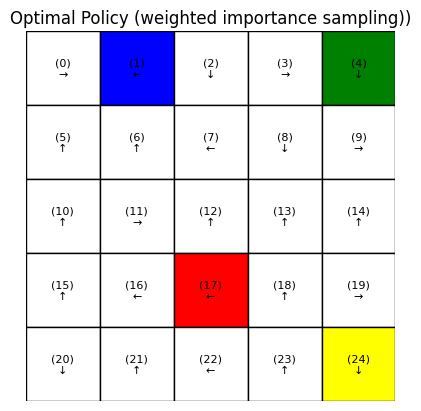

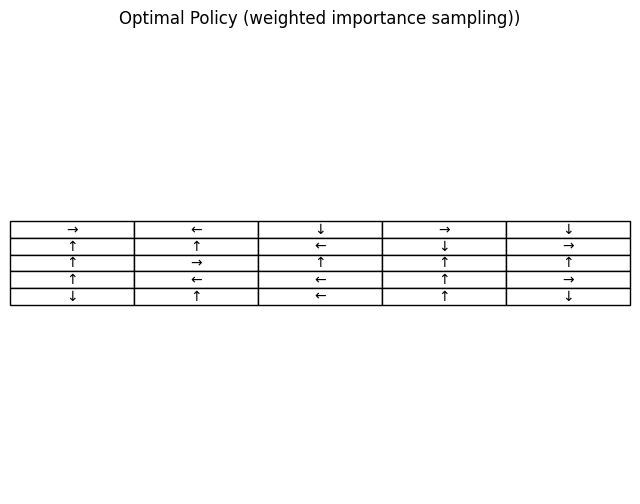

In [218]:
# Define the behaviour policy (equiprobable moves)
behaviour_policy = {s: {a: 0.25 for a in actions} for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}

# Off-policy Monte Carlo control using weighted importance sampling
def off_policy_mc_control(episodes, gamma=0.95):
    Q = {s: {a: 0 for a in actions} for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}
    C = {s: {a: 0 for a in actions} for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}
    target_policy = {s: np.random.choice(actions) for s in Q}
    
    for episode in range(episodes):
        state = (np.random.choice(range(grid_size)), np.random.choice(range(grid_size)))
        episode_data = []
        while state not in terminal_states:
            action = np.random.choice(actions)
            next_state, reward = step(state, action)
            episode_data.append((state, action, reward))
            if next_state in terminal_states:
                break
            state = next_state
        
        G = 0
        W = 1
        for state, action, reward in reversed(episode_data):
            G = gamma * G + reward
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            target_policy[state] = max(Q[state], key=Q[state].get)
            if action != target_policy[state]:
                break
            W *= 1 / behaviour_policy[state][action]
    
    return target_policy, Q

# Off-policy control
policy_off_policy, Q_off_policy = off_policy_mc_control(1000)
print("Optimal Policy (weighted importance sampling):")
print(policy_off_policy)

# Initialize a 5x5 grid with zeros
grid_size = 5
policy_grid = np.zeros((grid_size, grid_size), dtype=int)

action_mapping = {"up": 0, "down" : 1, "left": 2, "right": 3}

# Populate the grid with numerical values based on the policy
for (row, col), action in policy_off_policy.items():
    policy_grid[row, col] = action_mapping[action]

# Print the policy grid
for row in policy_grid:
    print(row)
    
# Action to textual value mapping
action_text_mapping = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Create the plot
fig, ax = plt.subplots()

# Define the colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(grid_size):
    for j in range(grid_size):
        state = i * grid_size + j
        action = policy_grid[i, j]
        action_text = action_text_mapping[action]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{action_text}', ha='center', va='center', fontsize=8)

# Set the limits and aspect of the plot
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_aspect('equal')
ax.axis('off')

# Add a title to the plot
plt.title("Optimal Policy (weighted importance sampling))")

# Show the plot
plt.gca().invert_yaxis()
plt.show()

# Plot the off-policy optimal policy
plot_policy(policy_off_policy, "Optimal Policy (weighted importance sampling))")

##  2.3 Policy Iteration with state permutations


Optimal Policy (Policy Iteration with Permutations):
{(0, 0): 'right', (0, 1): 'down', (0, 2): 'left', (0, 3): 'down', (0, 4): 'down', (1, 0): 'right', (1, 1): 'up', (1, 2): 'left', (1, 3): 'right', (1, 4): 'up', (2, 0): 'up', (2, 1): 'up', (2, 2): 'up', (2, 3): 'up', (2, 4): 'up', (3, 0): 'down', (3, 1): 'up', (3, 2): 'up', (3, 3): 'right', (3, 4): 'right', (4, 0): 'right', (4, 1): 'left', (4, 2): 'up', (4, 3): 'up', (4, 4): 'up'}
{(0, 0): 0.18844442244180265, (0, 1): 0.9653198937483399, (0, 2): 0.022028684791506534, (0, 3): -0.44504156785532095, (0, 4): -0.3211623065241863, (1, 0): 0.9246166796702795, (1, 1): 4.046452059053287, (1, 2): 0.7081959514194488, (1, 3): 0.028098287618738102, (1, 4): 1.208706580160843, (2, 0): -0.10863379440094469, (2, 1): 0.5010665403672696, (2, 2): -0.2726585253932088, (2, 3): -0.5114814834863778, (2, 4): -0.14348366705581994, (3, 0): -0.6166695928622334, (3, 1): -0.7133602330742358, (3, 2): -1.0037599801013948, (3, 3): -0.9234850337025433, (3, 4): 0, (4, 

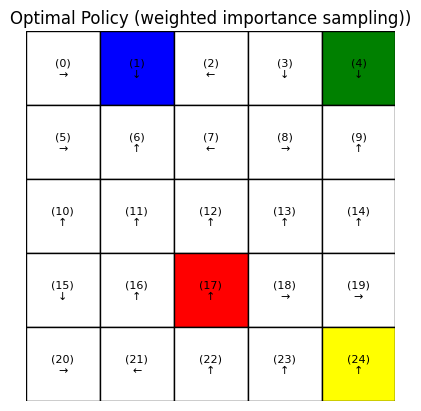

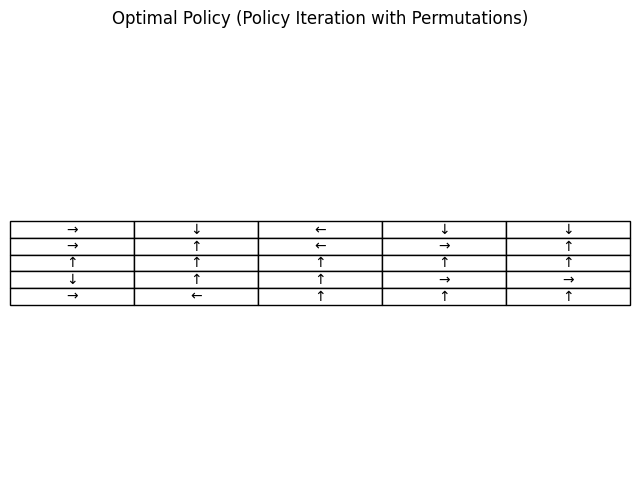

In [219]:
# Define the grid size and special state rewards
grid_size = 5
special_states = {
    (1, 1): {'reward': 5, 'next_state': (3, 2)},    # Blue state jumps to red state
    (1, 4): {'reward': 2.5, 'next_state': (3, 2)},  # Green state jumps to  red
    (1, 4): {'reward': 2.5, 'next_state': (4, 4)},  # Green state jumps to yellow
}

# Define terminal states
terminal_states = [(4, 0), (3, 4)]

# Define the action space (up, down, left, right)
actions = ['up', 'down', 'left', 'right']

# Function to get the next state and reward considering permutations
def step(state, action, permuted_states):
    if state in terminal_states:
        return state, 0  # No movement from terminal states

    row, col = state
    if action == 'up':
        next_row, next_col = max(row - 1, 0), col
    elif action == 'down':
        next_row, next_col = min(row + 1, grid_size - 1), col
    elif action == 'left':
        next_row, next_col = row, max(col - 1, 0)
    elif action == 'right':
        next_row, next_col = row, min(col + 1, grid_size - 1)
    next_state = (next_row, next_col)

    if state in permuted_states:
        reward = permuted_states[state]['reward']
        next_state = permuted_states[state]['next_state']
        if isinstance(next_state, list):
            next_state = tuple(np.random.choice(next_state))
    else:
        reward = -0.2 if next_state != state else -0.5

    return next_state, reward

# Function to permute the green and blue squares
def permute_special_states(prob=0.1):
    if random.random() < prob:
        permuted_states = {
            (1, 4): {'reward': 5, 'next_state': (3, 2)},    # Green state jumps to red state
            (1, 1): {'reward': 2.5, 'next_state': (3, 2)},  # Blue state jumps to  red
            (1, 1): {'reward': 2.5, 'next_state': (4, 4)},  # Blue state jumps to yellow
        }
    else:
        permuted_states = special_states
    return permuted_states

# Policy Iteration with state permutations
def policy_iteration_with_permutations(episodes, gamma=0.95, prob=0.1):
    policy = {s: np.random.choice(actions) for s in [(r, c) for r in range(grid_size) for c in range(grid_size)]}
    V = {s: 0 for s in policy.keys()}
    
    for episode in range(episodes):
        permuted_states = permute_special_states(prob)
        delta = 0
        for state in policy.keys():
            if state in terminal_states:
                continue
            v = V[state]
            V[state] = sum([0.25 * (reward + gamma * V[next_state]) 
                            for action in actions
                            for next_state, reward in [step(state, action, permuted_states)]])
            delta = max(delta, abs(v - V[state]))
        if delta < 1e-4:
            break
    
    for state in policy.keys():
        if state in terminal_states:
            continue
        permuted_states = permute_special_states(prob)
        action_values = {}
        for action in actions:
            action_values[action] = sum([reward + gamma * V[next_state]
                                         for next_state, reward in [step(state, action, permuted_states)]])
        best_action = max(action_values, key=action_values.get)
        policy[state] = best_action
    
    return policy, V

policy_permuted, V_permuted = policy_iteration_with_permutations(1000)
print("Optimal Policy (Policy Iteration with Permutations):")
print(policy_permuted)
print(V_permuted)
# for state, action in policy_permuted.items():
#     print(state, action)

# Initialize a 5x5 grid with zeros
grid_size = 5
policy_grid = np.zeros((grid_size, grid_size), dtype=int)

# Populate the grid with numerical values based on the policy
for (row, col), action in policy_permuted.items():
    policy_grid[row, col] = action_mapping[action]

# Print the policy grid
for row in policy_grid:
    print(row)
    
# Action to textual value mapping
action_text_mapping = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Create the plot
fig, ax = plt.subplots()

# Define the colors for special states
color_map = {
    (0, 1): 'blue',
    (0, 4): 'green',
    (3, 2): 'red',
    (4, 4): 'yellow'
}

# Draw the grid
for i in range(grid_size):
    for j in range(grid_size):
        state = i * grid_size + j
        action = policy_grid[i, j]
        action_text = action_text_mapping[action]
        color = color_map.get((i, j), 'white')
        rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        plt.text(j + 0.5, i + 0.5, f'({state})\n{action_text}', ha='center', va='center', fontsize=8)

# Set the limits and aspect of the plot
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_aspect('equal')
ax.axis('off')

# Add a title to the plot
plt.title("Optimal Policy (weighted importance sampling))")

# Show the plot
plt.gca().invert_yaxis()
plt.show()

plot_policy(policy_permuted, "Optimal Policy (Policy Iteration with Permutations)")

## Conclusion

In this project, we explored various reinforcement learning techniques to solve and optimize policies for a gridworld environment. The gridworld problem provides a straightforward yet insightful platform for comparing different algorithms. 

#### Key Steps and Findings

1. **Environment Setup**:
   - We began by defining a 5x5 gridworld environment with special states having unique rewards and transitions. This setup allowed us to simulate and analyze the agent's behavior in a controlled setting.

2. **Value Function Calculation**:
   - Using the provided value function, we visualized the value for each state. The values represent the expected cumulative reward the agent would receive, starting from each state and following the given policy.

3. **Policy Evaluation and Improvement**:
   - We implemented and visualized the results of iterative policy evaluation. This step involved updating the value function based on the agent's interactions with the environment under a fixed policy until convergence.
   - Additionally, we plotted the optimal policy derived using Monte Carlo methods with exploring starts. The optimal policy directs the agent to maximize cumulative rewards by favoring high-reward states while avoiding terminal states.

4. **Policy Representation**:
   - We effectively visualized the optimal policy on the gridworld, displaying state numbers and actions using arrow symbols. This visual representation aids in understanding the agent's decision-making process at each state.

#### Summary of Results

- **Value Function**: The calculated value function provided insights into the expected rewards for each state. States with higher values indicated more favorable positions for the agent, primarily influenced by proximity to high-reward states and transition rules.
- **Optimal Policy**: The optimal policy, derived from Monte Carlo exploring starts, was visualized on the grid. It demonstrated the agent's strategic movement towards high-value states, ensuring maximum cumulative rewards while adhering to the defined transitions and rewards of special states.

#### Conclusion

This notebook effectively demonstrates the practical application of reinforcement learning algorithms to a gridworld problem. By comparing different methods for policy evaluation and improvement, we gained valuable insights into the strengths and nuances of each approach. The visualizations provided a clear understanding of the agent's behavior, aiding in the interpretation of complex policies and value functions.